# Fitting a model using scipy.optimize.leastsq
I am halfway through my [Google Summer of Code project](https://summerofcode.withgoogle.com/) with [Dipy](http://nipy.org/dipy/) under the Python Software Foundation and I have published a few short posts about the project before but in this post I am going to walk through the entire project from the start. This can also be a good tutorial if you want to learn about curve fitting in python, unit testing and getting started with Dipy, a diffusion imaging library in Python.

The first part of this post will cover general curve fitting with [leastsq](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html), plotting and writing unit tests. The second part will focus on Dipy and the specific model I am working on - The Intravoxel Incoherent motion model.

#### Development branch for the IVIM model in Github : (https://github.com/nipy/dipy/pull/1058)

## Curve fitting with leastsq
Mathematical models proposed to fit observed data can be charaterized by several parameters. The simplest model is a straight line characterised by the slope (m) and intercept (C). 

## y = mx + C

Given a set of data points, we can determine the parameters m and C by using least squares regression which minimizes the error between the actual data points and those predicted by the model function. To demonstrate how to use leastsq for fitting let us generate some data points by importing the library numpy, defining a linear function and making a scatter plot.

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
# This is a magic function that renders the plots in the Ipython notebook itself
% matplotlib inline 

Let us define a model function which is an exponential decay curve and depends on two parameters. 
### y = A exp(-x * B)
Documentation is important and we should write what each function does and specify the input and output parameters for each function.

In [141]:
# Define a linear model function
def func(params, x):
    """
    Model function. The function is defined by the following equation.
                    y = A exp(-x * B)
    Parameters
    ----------
    params : array (2,)
        An array with two elements, A and B
        
    x      : array (N,)
        The independent variable
    
    Returns
    -------
    y      : array (N,)
        The values of the dependent variable
    """
    A, B = params[0], params[1]
    return A*np.exp(-x*B)

Use numpy's arange to generate an array of "x" and apply the function to get a set of data points. We can add some noise by the use of the random number generator in numpy.

In [143]:
x = np.arange(0,400,10)
N = x.shape[0]
params = 1., 0.01
Y = func(params, x)
noise = np.random.rand(N)

y = Y + noise/5.

Let us make a scatter plot of our data

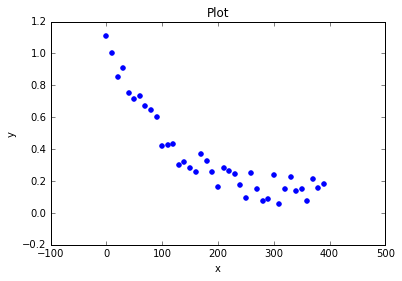

In [144]:
plt.scatter(x, y, color='blue')
plt.title("Plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now that we have a set of data points, we can go ahead with the fitting using leastsq. Leastsq is a wrapped around the FORTRAN package MINPACK’s lmdif and lmder algorithms. It uses the Levenberg Marquardt algorithm for finding the best fit parameters.

Leastsq requires an error function which gives the difference between the observed target data (y) and a (non-linear) function of the parameters f(x, params). You can also specify initial guesses for the parameters using the variable x0. For more reference check out the documentation at http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html

In [91]:
def error_fun(params, x, y):
    """
    Error function for model function.
    
    Parameters
    ----------
    params : array (2,)
        Parameters for the function
        
    x      : array (N,)
        The independent variable
    
    y      : array (N,)
        The observed variable
        
    Returns
    -------
    residual : array (N,)
        The difference between observed data and predicted data from the model function

    """
    residual = func(params, x) - y
    return residual

Now, we are ready to use leastsq for getting the fit. The call to leastsq returns an array whose first element is the set of parameters obtained and the other elements give more information about the fitting.

In [92]:
fit = leastsq(error_fun, x0=[0.5, 0.05], args=(x,y))
fitted_params = fit[0]
print ("Parameters after leastsq fit are :", fitted_params)

Parameters after leastsq fit are : [ 1.03770447  0.00783634]


Let us compare our fitting and plot the results.

[]

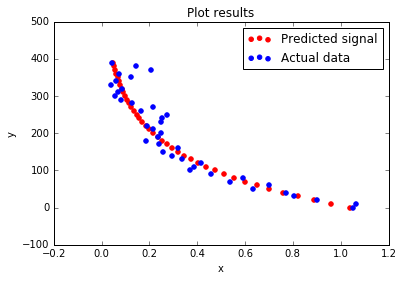

In [93]:
y_predicted = func(fitted_params, x)
plt.scatter(y_predicted, x, color="red", label="Predicted signal")
plt.scatter(y, x, color="blue", label="Actual data")
plt.title("Plot results")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.plot()

Congratualations ! You have done your first model fitting with Python. You can now look at other fitting routines such as scipy.optimize.minimize, use different types of model functions and try to write code for more complicated functions and data. But at the heart of it, its as simple as this basic example.  

# Writing unit tests

Unit testing is a software testing method by which individual units of source code, sets of one or more modules together are tested to determine whether they are fit for use. Unit tests are usually very simple to write and involve very elementary tests on the expected output of your code. In the current context, it can be as simple as checking if your fit gives back the same parameters you used to generate the data. We will be using numpy's unit testing suite for our test.

In [145]:
from numpy.testing import (assert_array_equal, assert_array_almost_equal)

def test_fit():
    """
    Test the implementation of leastsq fitting
    """
    x = np.arange(0,400,10)
    N = x.shape[0]
    params = 1., 0.01
    y = func(params, x)
    
    fit = leastsq(error_fun, x0=[0.5, 0.05], args=(x,y))
    fitted_params = fit[0]
    predicted_signal = func(fitted_params, x)
    
    # Check if fit returns parameters for noiseless simulated data
    assert_array_equal(params, fitted_params)
    assert_array_almost_equal(y, predicted_signal)

test_fit()

# Usually, the package nosetests is used for unit testing. You can run the command nosetest test_file.py to run
# all the tests for a module.

So your tests pass for a noiseless fit and you get back your original parameters. But what if there is noise in the data ? Let us write a more extreme version of the test and try to see if it fails.

In [146]:
def test_fit_with_noise():
    """
    Test the fitting in presence of noise
    """
    x = np.arange(0,400,10)
    N = x.shape[0]
    params = 1., 0.01
    Y = func(params, x)
    
    noise = np.random.rand(N)

    y = Y + noise/5.
    
    fit = leastsq(error_fun, x0=[0.5, 0.05], args=(x,y))
    fitted_params = fit[0]
    predicted_signal = func(fitted_params, x)
    
    # Check if fit returns parameters for noiseless simulated data
    assert_array_equal(params, fitted_params)
    assert_array_almost_equal(y, predicted_signal)

test_fit_with_noise()

AssertionError: 
Arrays are not equal

(mismatch 100.0%)
 x: array([ 1.  ,  0.01])
 y: array([ 1.079017,  0.007812])

## Thus, unit tests can make sure that your code is working properly and it behaves as it is expected to behave.

===================================================================================================================

# The Intravoxel incoherent motion model
The Intravoxel incoherent motion model assumes that biological tissue includes a volume fraction of water flowing in perfused capillaries, with a perfusion coefficient D\* and a fraction (1-f) of static (diffusion only), intra and extracellular water, with a diffusion coefficient D. Magnetic resonance imaging can be used to reconstruct a model of the brain (or any other tissue) using these parameters. Dipy is a python library for the analysis of diffusion MRI data. Let us get started by importing dipy, loading an image dataset and visualizing a slice of the brain. Dipy has "data fetchers" which can be used to download different datasets and read an image and load other attributes. We will use the Stanford HARDI dataset in this example. 

If you want an IVIM dataset you have to pull the `ivim_dev` branch from dipy to get the fetcher `read_ivim` and replace read_stanford_hardi with `read_ivim`. The dataset is provided by Eric Peterson. For more details refer to https://figshare.com/articles/IVIM_dataset/3395704

In [147]:
from dipy.data import read_ivim
img, gtab = read_ivim()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/shahnawaz/.dipy/ivim 


The function `read_stanford_hardi` downloads the dataset, reads it and returns two objects: an image and a gradient table. The gradient table has b-values and b-vectors which can be accessed by calling gtab.bvals and gtab.bvecs. The b-value is a factor that reflects the strength and timing of the gradients used to generate diffusion-weighted images. The higher the b-value, the stronger the diffusion effects.

In [148]:
print("b-values are :\n", gtab.bvals)

b-values are :
 [    0.    10.    20.    30.    40.    60.    80.   100.   120.   140.
   160.   180.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.]


"img" is a NIFTI image which can be explored using the nibabel library.

In [149]:
print(img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 54, 21)
affine: 
[[  -0.9375       -0.            0.          120.03099823]
 [  -0.            0.9375       -0.          -91.56149292]
 [   0.            0.            2.5         -75.15000153]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 256 256  54  21   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.      0.9375  0.9375  2.5     1.      0.      0.      0.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
sli

For our use, we just need the data which can be read by calling the get_data() method of the img object.

In [150]:
data = img.get_data()

The data has 54 slices, with 256-by-256 voxels in each slice. The fourth dimension corresponds to the b-values in the gtab.

In [151]:
print (data.shape)

(256, 256, 54, 21)


Let us take a slice of the data at a particular b value and height (z) and visualize it

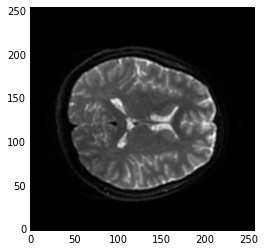

In [152]:
plt.imshow(data[:,:,31, 0], cmap='gray', origin ="lower")
plt.show()

Thus, for each b value we have a 3d matrix which gives us the signal value in a 256x256x54 box. To see how the signal in one of the points in this volume (one voxel) varies with bvalue, let us consider a random point from the data slice. Say we want the data in a 20x20 square at the height z=31 for all the bvalues, we specify the range of indices from our array using ":" as :

In [153]:
x1, x2 = 100, 120
y1, y2 = 150, 170
z = 31

data_slice = data[x1:x2, y1:y2, z, :]
print(data_slice.shape)

(20, 20, 21)


The data slice is now a 20x20 portion with the third dimension specifying the bvalues. We can visulaize this slice at a particular bvalue and extract the x and y data for the voxel located at (0,0) and for all bvals (:).

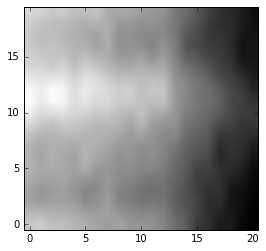

In [154]:
plt.imshow(data_slice[0], origin="lower", cmap="gray")
plt.show()

[]

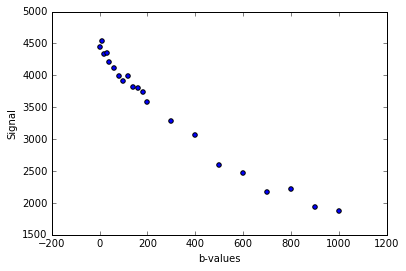

In [155]:
xdata = gtab.bvals
ydata = data_slice[0,0,:]

plt.scatter(xdata, ydata)
plt.xlabel("b-values")
plt.ylabel("Signal")
plt.plot()

The fitting method remains the same now. Let us try to fit the IVIM model function on this data and get IVIM parameters for this voxel. The IVIM model function is a bi exponential curve and has 4 parameters S0, f, D_star and D and is defined as follows : 
## S(b) = S0(f e^(- b D_star) + (1 - f) e^(-b D))

In [156]:
def ivim_function(params, bvals):
    """The Intravoxel incoherent motion (IVIM) model function.

        S(b) = S_0[f*e^{(-b*D\*)} + (1-f)e^{(-b*D)}]

        S_0, f, D\* and D are the IVIM parameters.

    Parameters
    ----------
        params : array
                parameters S0, f, D_star and D of the model

        bvals : array
                bvalues

    References
    ----------
    .. [1] Le Bihan, Denis, et al. "Separation of diffusion
               and perfusion in intravoxel incoherent motion MR
               imaging." Radiology 168.2 (1988): 497-505.
    .. [2] Federau, Christian, et al. "Quantitative measurement
               of brain perfusion with intravoxel incoherent motion
               MR imaging." Radiology 265.3 (2012): 874-881.
    """
    S0, f, D_star, D = params
    S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))
    return S


def _ivim_error(params, bvals, signal):
    """Error function to be used in fitting the IVIM model
    """
    return (signal - ivim_function(params, bvals))

Once we have our error function, we can use the same procedure to fit an IVIM model by using the leastsq function from scipy.optimize

In [157]:
x0 = [1000., 0.1, 0.01, 0.001]
fit = leastsq(_ivim_error,
              x0,
              args=(xdata, ydata),)

estimated_parameters = fit[0]
print('Parameters estimated using leastsq :', estimated_parameters)

Parameters estimated using leastsq : [  4.44684213e+03   1.41584992e-02  -1.88101978e-03   1.10032569e-03]


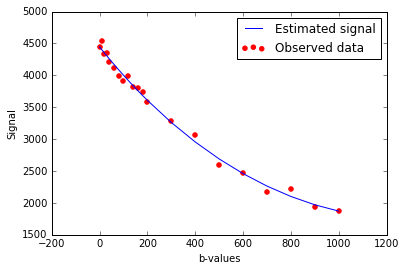

In [158]:
predicted_signal = ivim_function(estimated_parameters, xdata)

plt.plot(xdata, predicted_signal, label="Estimated signal")
plt.scatter(xdata, ydata, color="red", label="Observed data")
plt.xlabel("b-values")
plt.ylabel("Signal")
plt.legend()
plt.show()

### This forms the core of the project and once you get the hang of this, you can easily implement any new model for fitting data.